## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## title and description plus back ground

In [5]:
import numpy as np
import pandas as pd
import math
#import keras
import datetime
import os, shutil
import matplotlib.pyplot as plt
import sys
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Making new data directories
#only run once or you will receive an error
test_folder ='split/test/'
train_folder = 'split/train/'
val_folder ='split/validation/'
split ='split/'

folders = [split, val_folder, train_folder, test_folder]

for folder in folders:
    os.mkdir(folder)

In [6]:
# import all stock prices 
df = pd.read_csv("nyse/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


## There are a number of useful pieces o

Lets see how many stocks there are in our dataset.

In [7]:
print("There are {} stocks.".format(len(set(df.symbol))))

There are 501 stocks.


In [9]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


explaining some stats here 

Looking at a single stock

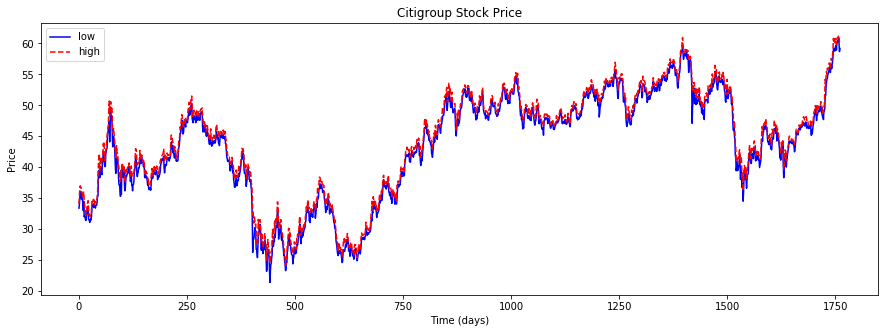

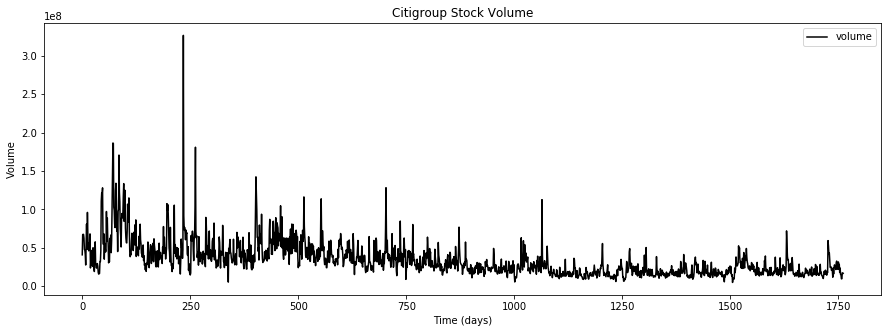

In [24]:
plt.figure(figsize=(15, 5));

plt.plot(df[df.symbol == 'C'].low.values, color='blue',linestyle = '-', label='low')
plt.plot(df[df.symbol == 'C'].high.values, color='red',linestyle = '--', label='high')
plt.title('Citigroup Stock Price')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(15, 5));
plt.plot(df[df.symbol == 'C'].volume.values, color='black', label='volume')
plt.title('Citigroup Stock Volume')
plt.xlabel('Time (days)')
plt.ylabel('Volume')
plt.legend(loc='best')
plt.show()

looking at the high values of all stocks


In [33]:
def get_max_high(sym):
    highs = df[df['symbol'] == sym].high.values
    return(max(highs))

In [36]:
highs = []
stocks = list(set(df.symbol))
for sym in stocks:
    highs.append(get_max_high(sym))

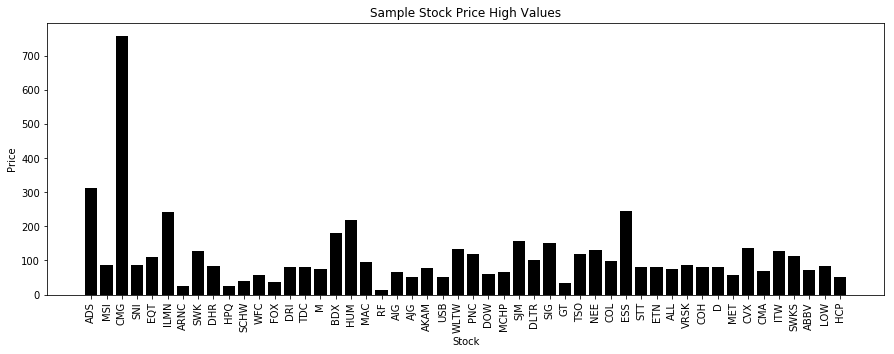

In [47]:
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],highs[:50], color='black')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price High Values')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

Doing the same for stock lows

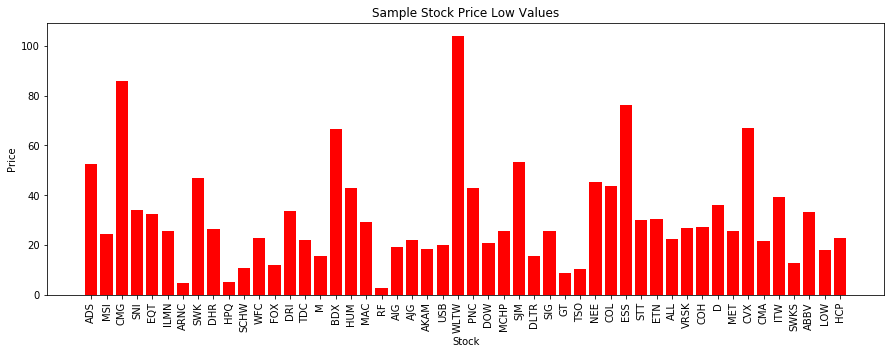

In [49]:
def get_min_low(sym):
    lows = df[df['symbol'] == sym].low.values
    return(min(lows))
lows = []
for sym in stocks:
    lows.append(get_min_low(sym))
    
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],lows[:50], color='red')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price Low Values')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

together for comparison



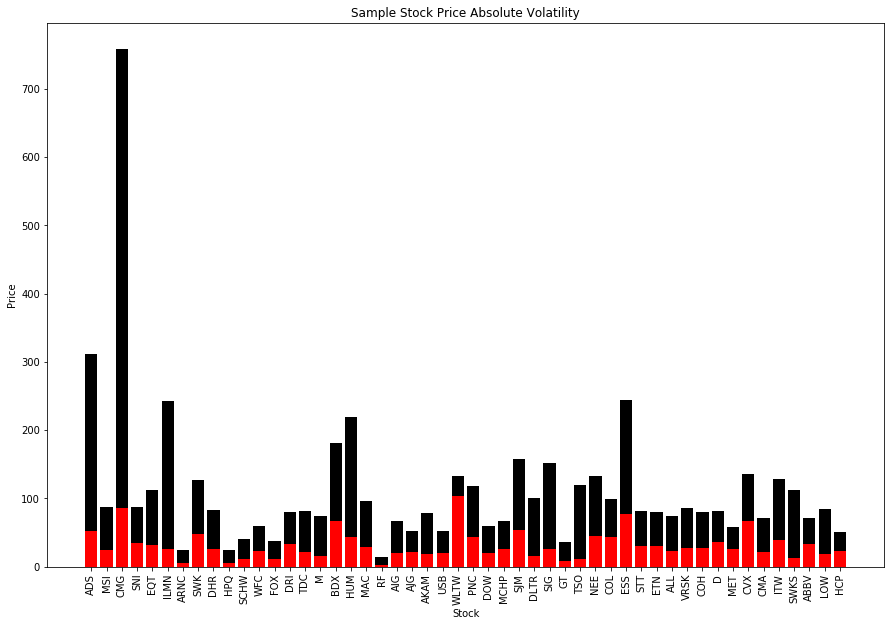

In [50]:
plt.figure(figsize=(15, 10))
plt.bar(stocks[:50],highs[:50], color='black')
plt.bar(stocks[:50],lows[:50], color='red')
plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Price Absolute Volatility')
plt.ylabel('Price')
plt.xlabel('Stock')
plt.show()

talk about risk management and seeing recent highest hghs and lowest lows

trade volume for every friday in jan 2015

In [88]:
jan2= df.loc['2015-01-02']
jan2_vol = jan2.volume.values

jan9= df.loc['2015-01-09']
jan9_vol = jan9.volume.values

jan16= df.loc['2015-01-16']
jan16_vol = jan16.volume.values

jan23= df.loc['2015-01-23']
jan23_vol = jan23.volume.values

jan30= df.loc['2015-01-30']
jan30_vol = jan30.volume.values



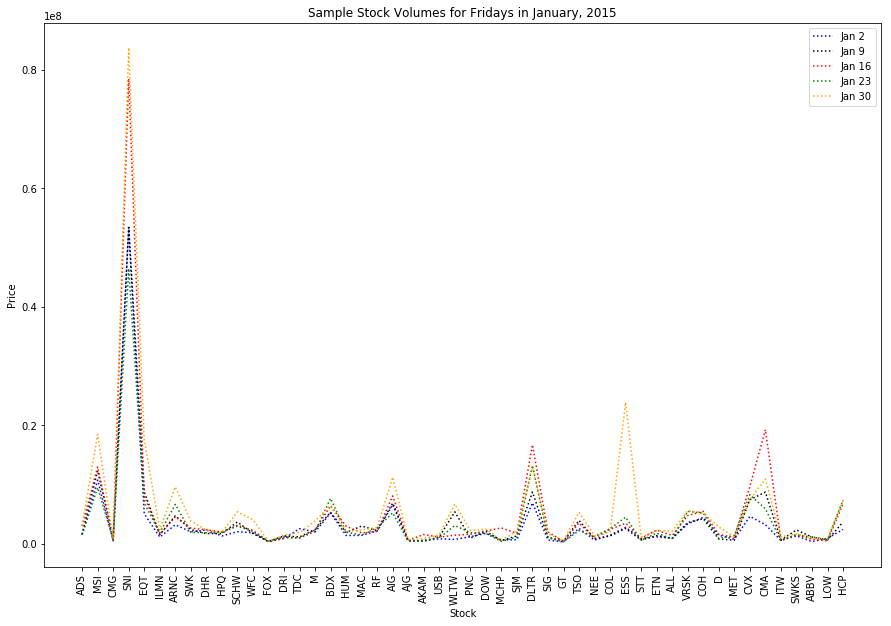

In [90]:
plt.figure(figsize=(15,10))
plt.plot(stocks[:50], jan2_vol[:50],color='blue',linestyle = ':',label='Jan 2')
plt.plot(stocks[:50], jan9_vol[:50],color='black',linestyle = ':',label='Jan 9')
plt.plot(stocks[:50], jan16_vol[:50],color='red',linestyle = ':',label='Jan 16')
plt.plot(stocks[:50], jan23_vol[:50],color='green',linestyle = ':',label='Jan 23')
plt.plot(stocks[:50], jan30_vol[:50],color='orange',linestyle = ':',label='Jan 30')

plt.xticks(stocks[:50], rotation='vertical')
plt.title('Sample Stock Volumes for Fridays in January, 2015' )
plt.ylabel('Price')
plt.xlabel('Stock')
plt.legend(loc='best')
plt.show()

open and close

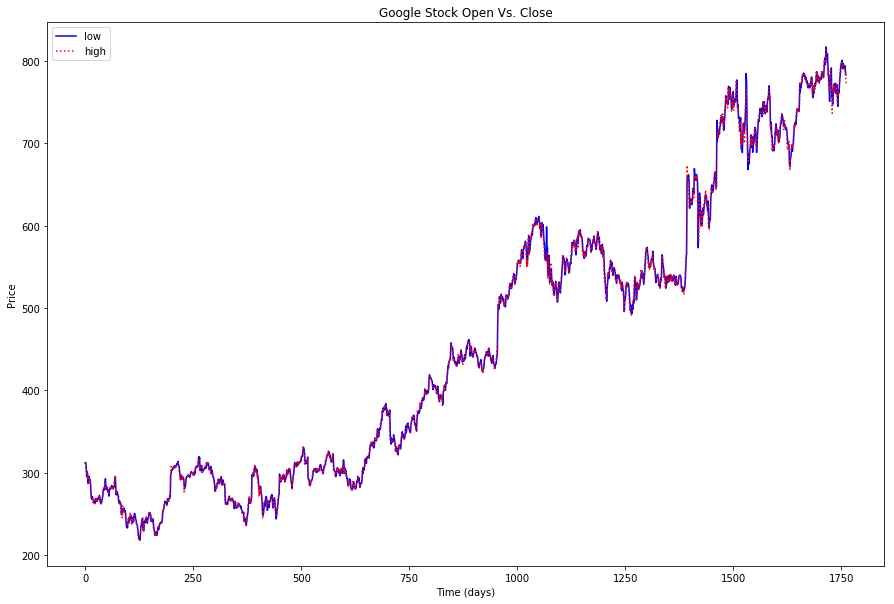

In [95]:
plt.figure(figsize=(15, 10));

plt.plot(df[df.symbol == 'GOOG'].open.values, color='blue',linestyle = '-', label='low')
plt.plot(df[df.symbol == 'GOOG'].close.values, color='red',linestyle = ':', label='high')
plt.title('Google Stock Open Vs. Close')
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()